In [9]:
import torch

print("hello world")

hello world


In [10]:
print(f"Torch version: {torch.__version__}")
print(torch.cuda.is_available())

print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Torch version: 2.5.1+cu124
True
1
cuda


In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path


class SongFeatureExplorer:
    def __init__(self, song_folder_path):
        self.song_path = Path(song_folder_path)
        self.h5_files = sorted([f for f in os.listdir(song_folder_path) if f.endswith(".h5")])

    def explore_file_structure(self):
        """
        Print the structure of first h5 file to understand its organization
        """
        if self.h5_files:
            first_file = self.song_path / self.h5_files[0]
            with h5py.File(first_file, "r") as f:
                print("\nExploring structure of:", first_file.name)
                self._print_structure(f)

    def _print_structure(self, obj, level=0):
        """
        Recursively print h5 file structure with proper indentation
        """
        indent = "  " * level
        for key in obj.keys():
            if isinstance(obj[key], h5py.Dataset):
                print(f"{indent}Dataset: {key}, Shape: {obj[key].shape}")
            else:
                print(f"{indent}Group: {key}")
                self._print_structure(obj[key], level + 1)

    def load_all_covers(self, feature_type="hpcp"):
        """
        Load feature data from all covers
        """
        covers = []
        for h5_file in self.h5_files:
            try:
                file_path = self.song_path / h5_file
                with h5py.File(file_path, "r") as f:
                    # First, let's see what we have in the file
                    if len(f.keys()) == 0:
                        print(f"Warning: No data in {h5_file}")
                        continue

                    # Get the data based on file structure
                    if feature_type in f:  # If feature is at root level
                        feature_data = f[feature_type][:]
                        covers.append(feature_data)
                    else:  # Try to find feature in first group
                        first_group = list(f.keys())[0]
                        if feature_type in f[first_group]:
                            feature_data = f[first_group][feature_type][:]
                            covers.append(feature_data)
                        else:
                            print(f"Warning: {feature_type} not found in {h5_file}")

            except Exception as e:
                print(f"Error processing {h5_file}: {str(e)}")

        return covers

    def plot_all_covers(self, feature_type="hpcp"):
        """
        Plot all covers 
        """
        covers = self.load_all_covers(feature_type)

        if not covers:
            print(f"No {feature_type} features found in any of the files")
            return

        # Create figure with subplots
        n_covers = len(covers)
        fig, axes = plt.subplots(n_covers, 1, figsize=(15, 4 * n_covers))
        if n_covers == 1:
            axes = [axes]

        # Plot each cover
        for idx, (ax, cover) in enumerate(zip(axes, covers)):
            im = ax.imshow(cover.T, aspect="auto", origin="lower", interpolation="nearest", cmap="viridis")
            ax.set_title(f"cover {idx+1} - Shape: {cover.shape}")
            ax.set_ylabel("Pitch Class")
            plt.colorbar(im, ax=ax)

        axes[-1].set_xlabel("Time Frame")
        plt.suptitle(f"{feature_type.upper()} Features Across All covers", y=1.02)
        plt.tight_layout()
        plt.show()

        # Print statistics for each cover
        print("\ncover Statistics:")
        for idx, cover in enumerate(covers):
            print(f"\ncover {idx+1}:")
            print(f"Shape: {cover.shape}")
            print(f"Mean: {np.mean(cover):.3f}")
            print(f"Std: {np.std(cover):.3f}")
            print(f"Range: [{np.min(cover):.3f}, {np.max(cover):.3f}]")


Exploring structure of: P_165834_hpcp.h5
Dataset: hpcp, Shape: (33978, 12)


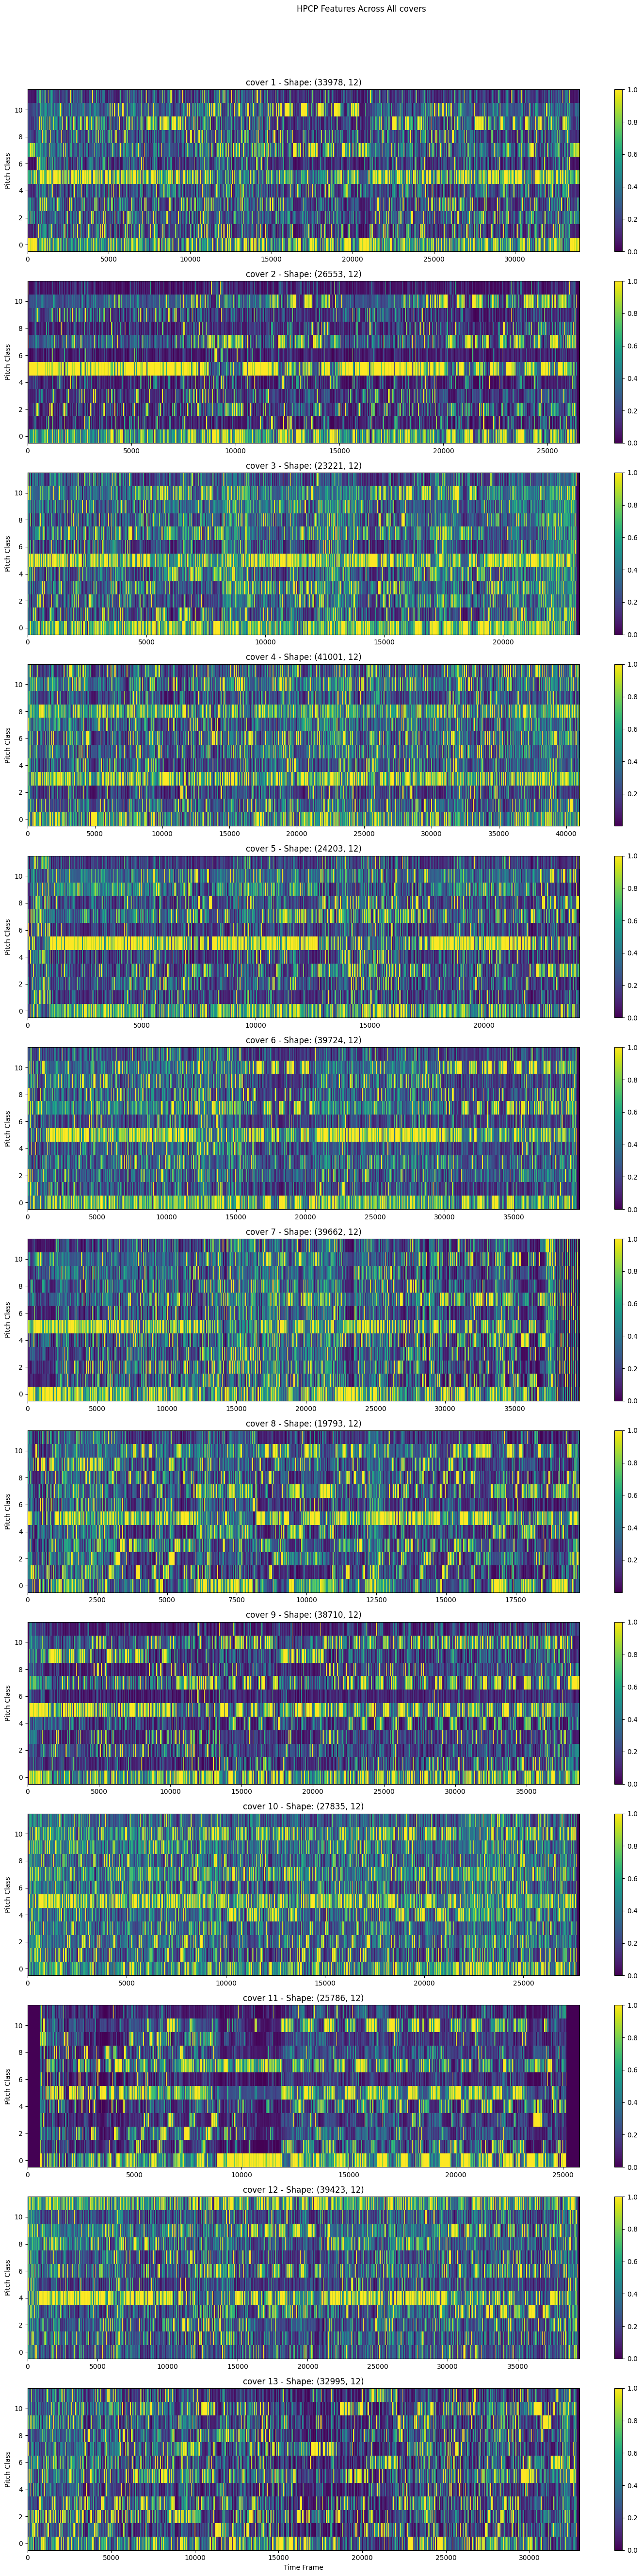


cover Statistics:

cover 1:
Shape: (33978, 12)
Mean: 0.391
Std: 0.297
Range: [0.000, 1.000]

cover 2:
Shape: (26553, 12)
Mean: 0.319
Std: 0.312
Range: [0.000, 1.000]

cover 3:
Shape: (23221, 12)
Mean: 0.443
Std: 0.287
Range: [0.000, 1.000]

cover 4:
Shape: (41001, 12)
Mean: 0.424
Std: 0.290
Range: [0.001, 1.000]

cover 5:
Shape: (24203, 12)
Mean: 0.389
Std: 0.297
Range: [0.000, 1.000]

cover 6:
Shape: (39724, 12)
Mean: 0.406
Std: 0.290
Range: [0.000, 1.000]

cover 7:
Shape: (39662, 12)
Mean: 0.392
Std: 0.298
Range: [0.000, 1.000]

cover 8:
Shape: (19793, 12)
Mean: 0.388
Std: 0.301
Range: [0.000, 1.000]

cover 9:
Shape: (38710, 12)
Mean: 0.341
Std: 0.307
Range: [0.000, 1.000]

cover 10:
Shape: (27835, 12)
Mean: 0.453
Std: 0.276
Range: [0.000, 1.000]

cover 11:
Shape: (25786, 12)
Mean: 0.324
Std: 0.309
Range: [0.000, 1.000]

cover 12:
Shape: (39423, 12)
Mean: 0.405
Std: 0.291
Range: [0.000, 1.000]

cover 13:
Shape: (32995, 12)
Mean: 0.365
Std: 0.304
Range: [0.000, 1.000]


In [12]:
explorer = SongFeatureExplorer(r"D:\TACOS\da-tacos_benchmark_subset_hpcp\da-tacos_benchmark_subset_hpcp\W_18_hpcp")
explorer.explore_file_structure()
explorer.plot_all_covers("hpcp")


Exploring structure of: P_165834_crema.h5
Dataset: crema, Shape: (33976, 12)


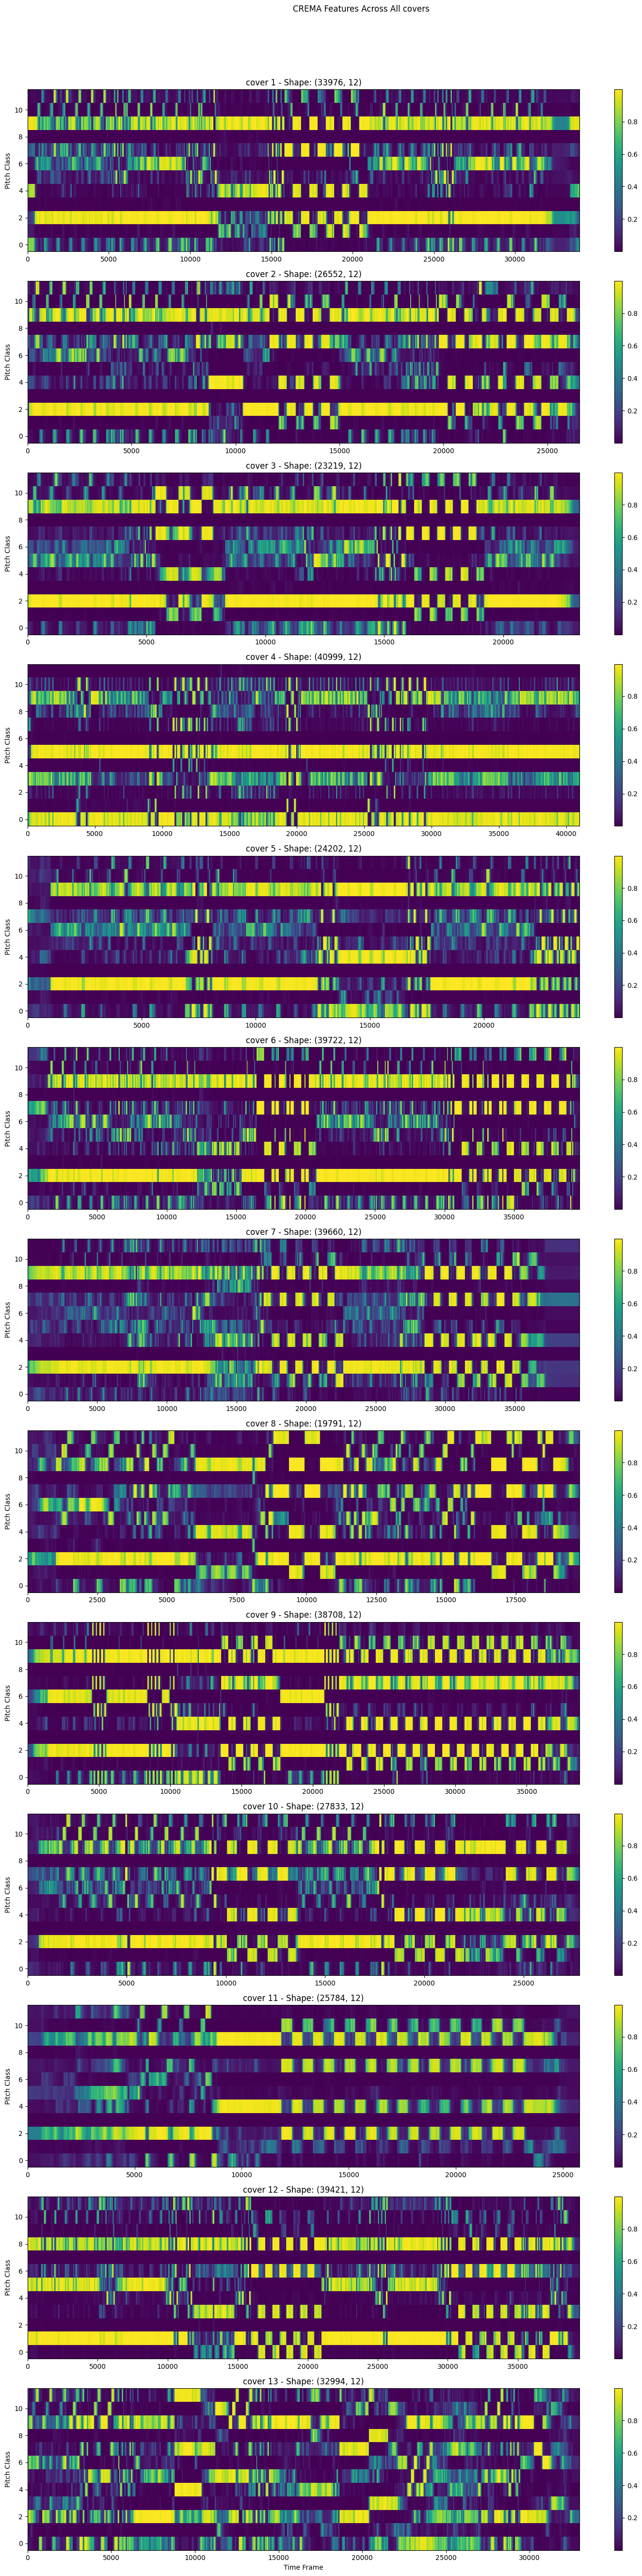


cover Statistics:

cover 1:
Shape: (33976, 12)
Mean: 0.259
Std: 0.358
Range: [0.000, 0.999]

cover 2:
Shape: (26552, 12)
Mean: 0.251
Std: 0.359
Range: [0.000, 0.999]

cover 3:
Shape: (23219, 12)
Mean: 0.265
Std: 0.359
Range: [0.000, 0.998]

cover 4:
Shape: (40999, 12)
Mean: 0.275
Std: 0.370
Range: [0.000, 0.998]

cover 5:
Shape: (24202, 12)
Mean: 0.252
Std: 0.344
Range: [0.000, 0.999]

cover 6:
Shape: (39722, 12)
Mean: 0.242
Std: 0.355
Range: [0.000, 0.999]

cover 7:
Shape: (39660, 12)
Mean: 0.238
Std: 0.321
Range: [0.000, 0.998]

cover 8:
Shape: (19791, 12)
Mean: 0.251
Std: 0.358
Range: [0.000, 0.999]

cover 9:
Shape: (38708, 12)
Mean: 0.267
Std: 0.391
Range: [0.000, 0.999]

cover 10:
Shape: (27833, 12)
Mean: 0.229
Std: 0.339
Range: [0.000, 0.998]

cover 11:
Shape: (25784, 12)
Mean: 0.208
Std: 0.314
Range: [0.000, 0.995]

cover 12:
Shape: (39421, 12)
Mean: 0.248
Std: 0.367
Range: [0.000, 0.999]

cover 13:
Shape: (32994, 12)
Mean: 0.260
Std: 0.334
Range: [0.000, 0.998]


In [13]:
explorer = SongFeatureExplorer(r"D:\TACOS\da-tacos_benchmark_subset_crema\da-tacos_benchmark_subset_crema\W_18_crema")
explorer.explore_file_structure()
explorer.plot_all_covers("crema")

In [14]:
import h5py
import numpy as np
from pathlib import Path
import os
from scipy.spatial.distance import cosine
from dtaidistance import dtw
from scipy import stats


class FeatureComparator:
    def __init__(self, song_folder_path):
        self.song_path = Path(song_folder_path)
        self.h5_files = sorted([f for f in os.listdir(song_folder_path) if f.endswith(".h5")])
        self.work_id = self.song_path.name.split("_")[1]

    def compute_feature_similarity(self, feature_type="crema"):
        features = []
        perf_ids = []

        # Load all features
        for h5_file in self.h5_files:
            try:
                with h5py.File(self.song_path / h5_file, "r") as f:
                    # Get feature data
                    if feature_type in f:
                        feature_data = f[feature_type][:]
                    else:
                        first_key = list(f.keys())[0]
                        feature_data = f[first_key][:]

                    features.append(feature_data)
                    perf_ids.append(h5_file.split(".")[0])

            except Exception as e:
                print(f"Error loading {h5_file}: {str(e)}")
                continue

        if len(features) < 2:
            print("Not enough features loaded for comparison")
            return

        print(f"\nAnalyzing Work ID: {self.work_id}")
        print(f"Number of performances: {len(features)}")

        # Compute similarities between all pairs
        similarities = []
        for i in range(len(features)):
            for j in range(i + 1, len(features)):
                sim = self._compute_similarity_metrics(features[i], features[j])
                similarities.append({"perf1": perf_ids[i], "perf2": perf_ids[j], "metrics": sim})

        # Print results
        self._print_similarity_results(similarities)

    def _compute_similarity_metrics(self, feat1, feat2):
        """
        Compute multiple similarity metrics between two feature sequences,
        handling different sequence lengths.
        """
        # Get global statistics for each sequence
        stats1 = self._compute_sequence_stats(feat1)
        stats2 = self._compute_sequence_stats(feat2)

        # Compute statistical similarity
        stat_sim = self._compare_statistics(stats1, stats2)

        # Compute frame-level similarities using sequence averaging
        frame_sim = self._compute_frame_similarities(feat1, feat2)

        return {**stat_sim, **frame_sim}

    def _compute_sequence_stats(self, feat):
        """
        Compute statistical properties of the feature sequence
        """
        return {"mean": np.mean(feat), "std": np.std(feat), "max": np.max(feat), "min": np.min(feat), "median": np.median(feat), "q1": np.percentile(feat, 25), "q3": np.percentile(feat, 75)}

    def _compare_statistics(self, stats1, stats2):
        """
        Compare statistical properties between sequences
        """
        return {
            "mean_diff": abs(stats1["mean"] - stats2["mean"]),
            "std_ratio": stats1["std"] / stats2["std"] if stats2["std"] != 0 else float("inf"),
            "range_overlap": min(stats1["max"], stats2["max"]) - max(stats1["min"], stats2["min"]),
            "iqr_ratio": ((stats1["q3"] - stats1["q1"]) / (stats2["q3"] - stats2["q1"]) if (stats2["q3"] - stats2["q1"]) != 0 else float("inf")),
        }

    def _compute_frame_similarities(self, feat1, feat2):
        """
        Compute frame-level similarities between sequences of different lengths
        """
        # Compute average feature vectors
        avg1 = np.mean(feat1, axis=0)
        avg2 = np.mean(feat2, axis=0)

        # Compute cosine similarity between average vectors
        cos_sim = 1 - cosine(avg1, avg2)

        # Compute correlation between average patterns
        corr = stats.pearsonr(avg1, avg2)[0]

        # Compute normalized Euclidean distance
        eucl_dist = np.linalg.norm(avg1 - avg2) / np.sqrt(len(avg1))

        return {"cosine_similarity": cos_sim, "correlation": corr, "euclidean_distance": eucl_dist}

    def _print_similarity_results(self, similarities):
        """
        Print similarity analysis results in a structured format
        """
        print("\nPairwise Similarity Analysis:")
        print("=" * 50)

        # Find most and least similar pairs
        most_similar = max(similarities, key=lambda x: x["metrics"]["cosine_similarity"])
        least_similar = min(similarities, key=lambda x: x["metrics"]["cosine_similarity"])

        for sim in similarities:
            print(f"\nComparing {sim['perf1']} vs {sim['perf2']}:")
            print(f"Cosine Similarity: {sim['metrics']['cosine_similarity']:.3f}")
            print(f"Correlation: {sim['metrics']['correlation']:.3f}")
            print(f"Euclidean Distance: {sim['metrics']['euclidean_distance']:.3f}")
            print(f"Statistical Differences:")
            print(f"  Mean Difference: {sim['metrics']['mean_diff']:.3f}")
            print(f"  Std Ratio: {sim['metrics']['std_ratio']:.3f}")
            print(f"  Range Overlap: {sim['metrics']['range_overlap']:.3f}")

        print("\nSummary:")
        print(f"Most similar pair: {most_similar['perf1']} - {most_similar['perf2']}")
        print(f"Least similar pair: {least_similar['perf1']} - {least_similar['perf2']}")


# Example usage:
# comparator = FeatureComparator('path_to_song_folder')
# comparator.compute_feature_similarity('crema')

In [15]:
comparator = FeatureComparator(r"D:\TACOS\da-tacos_benchmark_subset_hpcp\da-tacos_benchmark_subset_hpcp\W_18_hpcp")
comparator.compute_feature_similarity("hpcp")  # or 'hpcp'


Analyzing Work ID: 18
Number of performances: 13

Pairwise Similarity Analysis:

Comparing P_165834_hpcp vs P_287459_hpcp:
Cosine Similarity: 0.967
Correlation: 0.960
Euclidean Distance: 0.108
Statistical Differences:
  Mean Difference: 0.072
  Std Ratio: 0.952
  Range Overlap: 1.000

Comparing P_165834_hpcp vs P_361600_hpcp:
Cosine Similarity: 0.998
Correlation: 0.975
Euclidean Distance: 0.060
Statistical Differences:
  Mean Difference: 0.052
  Std Ratio: 1.036
  Range Overlap: 1.000

Comparing P_165834_hpcp vs P_3849_hpcp:
Cosine Similarity: 0.921
Correlation: 0.101
Euclidean Distance: 0.172
Statistical Differences:
  Mean Difference: 0.034
  Std Ratio: 1.026
  Range Overlap: 0.999

Comparing P_165834_hpcp vs P_489866_hpcp:
Cosine Similarity: 0.996
Correlation: 0.971
Euclidean Distance: 0.036
Statistical Differences:
  Mean Difference: 0.001
  Std Ratio: 1.000
  Range Overlap: 1.000

Comparing P_165834_hpcp vs P_493609_hpcp:
Cosine Similarity: 0.997
Correlation: 0.971
Euclidean Dist

In [16]:
comparator = FeatureComparator(r"D:\TACOS\da-tacos_benchmark_subset_crema\da-tacos_benchmark_subset_crema\W_18_crema")
comparator.compute_feature_similarity("crema")  # or 'crema'


Analyzing Work ID: 18
Number of performances: 13

Pairwise Similarity Analysis:

Comparing P_165834_crema vs P_287459_crema:
Cosine Similarity: 0.971
Correlation: 0.940
Euclidean Distance: 0.087
Statistical Differences:
  Mean Difference: 0.008
  Std Ratio: 0.996
  Range Overlap: 0.999

Comparing P_165834_crema vs P_361600_crema:
Cosine Similarity: 0.984
Correlation: 0.966
Euclidean Distance: 0.067
Statistical Differences:
  Mean Difference: 0.006
  Std Ratio: 0.996
  Range Overlap: 0.998

Comparing P_165834_crema vs P_3849_crema:
Cosine Similarity: 0.443
Correlation: -0.054
Euclidean Distance: 0.414
Statistical Differences:
  Mean Difference: 0.016
  Std Ratio: 0.967
  Range Overlap: 0.998

Comparing P_165834_crema vs P_489866_crema:
Cosine Similarity: 0.985
Correlation: 0.969
Euclidean Distance: 0.063
Statistical Differences:
  Mean Difference: 0.007
  Std Ratio: 1.039
  Range Overlap: 0.999

Comparing P_165834_crema vs P_493609_crema:
Cosine Similarity: 0.993
Correlation: 0.986
Euc